In [1]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

In [2]:
pd.options.display.max_columns=100
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Read all the output

In [3]:
df = pd.read_csv("../results/data/processed_pcawg_escape_info.tsv",sep="\t").rename(columns={"sample":"sample_id"}) # Supp. Table 3

### Plot copy number integer

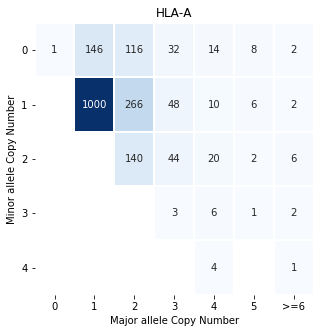

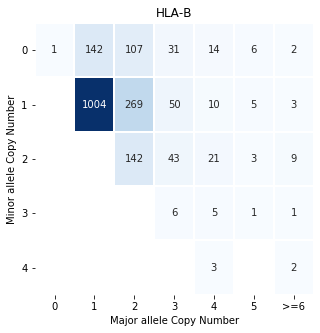

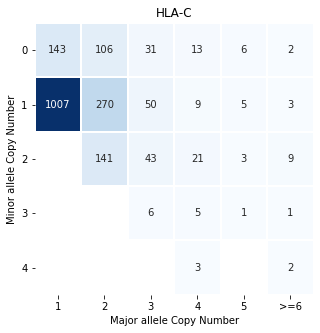

In [4]:
def plot_comparison_ploidy(df):
    lim=6
    for allele in ["HLA-A","HLA-B","HLA-C"]:
        x=np.array([np.nanmin([x,lim]) for x in df[f"ploidy_minor_{allele}"].values ])
        y=np.array([np.nanmin([x,lim]) for x in df[f"ploidy_major_{allele}"].values ])
        fig,ax = plt.subplots(figsize=(5,5))
        sns.heatmap(pd.crosstab(x,y,).replace(0, np.nan),cmap="Blues",annot=True,ax=ax,cbar=False,fmt='g',vmin=1,linewidths=1.)
        ax.set_xlabel("Major allele Copy Number")
        ax.set_ylabel("Minor allele Copy Number")
        ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
        ax.set_xticklabels(ax.get_xticklabels()[:-1]+[">=6"],rotation=0)
        ax.set_title(allele)
plot_comparison_ploidy(df)


### Plot raw copy number

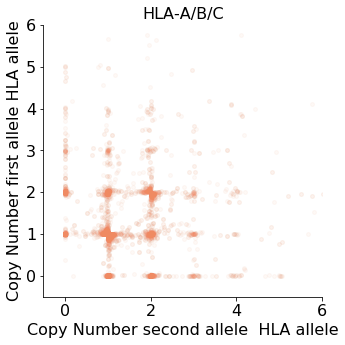

In [13]:
fig,ax = plt.subplots(figsize=(5,5))
for allele,color in zip(["A","B","C"],["#1b9e77","#d95f02","#7570b3"]):
    
    ax.scatter(df[allele+"1_CN"],df[allele+"2_CN"],alpha=0.05,color="#ef8a62",s=15)
    
    ax.set_title("HLA-A/B/C",fontsize=16)
#sns.kdeplot(df[allele+"1_CN"],df[allele+"2_CN"],shade=True,palette=cm.Greys,cut=0,shade_lowest=False,bw=0.1           )
ax.set_ylim(-0.5,6)
ax.set_xlim(-0.5,6)
ax.set_ylabel("Copy Number first allele HLA allele",fontsize=16)
ax.set_xlabel("Copy Number second allele  HLA allele",fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f'../results/figures/figure1/pcawg_copynumber_MHCI.png', dpi=800,bbox_inches="tight")



### Proportion of samples with Copy Number in non-integer number (between 0.3 and 0.7) 

In [5]:
from collections import defaultdict
k=defaultdict(int)
count=0
for a in ["A","B","C"]:
    for n1,n2 in zip(list(df[a+"1_CN"].values),list(df[a+"2_CN"])):
        if (n1 <= 0.3 or n1 >= 0.7) and (n2 <= 0.3 or n2 >= 0.7):
            k[a]+=1
            k["total"]+=1


##### Observe background genes :
-- generated with parse_cn_other_genes.py 


In [6]:
dh = pd.read_csv("data/cn_data_random_genes_pcawg.tsv.gz",sep="\t",names=["gene","minMinorAlleleCopyNumber","minCopyNumber","sampleId"])
dh=dh[dh["sampleId"].isin(df["sample_id"].values)]
dh.set_index("gene",inplace=True)

In [7]:
genes=list(set(dh.index))

In [8]:
from collections import defaultdict
other=defaultdict(int)
data={}
for gene in tqdm(genes[0:1000]):
    tmp=dh.loc[gene]
    minors= list(tmp["minMinorAlleleCopyNumber"].values)
    majors = list(tmp["minCopyNumber"].values - minors)
    data[gene] = (minors,majors)
    for i in range(0,len(minors)):
        number_dec = minors[i]
        number_dec_2 = majors[i]
        if (number_dec <= 0.3 or number_dec >= 0.7) and (number_dec_2 <= 0.3 or number_dec_2 >= 0.7):
            other[gene]+=1
values=[]
for v,c in other.items():
    values.append(c/df.shape[0])
    

100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


In [15]:
other=defaultdict(int)
data={}
for gene in tqdm(genes[0:1000]):
    tmp=dh.loc[gene]
    minors= list(tmp["minMinorAlleleCopyNumber"].values)
    majors = list(tmp["minCopyNumber"].values - minors)
    data[gene] = (minors,majors)
    for i in range(0,len(minors)):
        number_dec = float(str(majors[i]-int(majors[i]))[1:])
        number_dec_2 = float(str(minors[i]-int(minors[i]))[1:])
        if (number_dec > 0.3 and number_dec < 0.7) or (number_dec_2 > 0.3 and number_dec_2 < 0.7):
            other[gene]+=1
values=[]
for v,c in other.items():
    values.append(c/df.shape[0])
    

100%|██████████| 1000/1000 [01:45<00:00,  9.45it/s]


### Plot barplot with comparison

In [10]:
import random

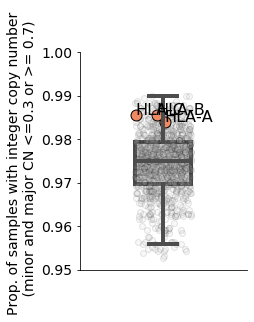

In [17]:
fig,ax = plt.subplots(figsize=(3,4))
j=0
colors=["#760b23ff","#2d1a67ff","#063b07ff"]

#ax.bar(x=j,height=np.nanmean(values),yerr=np.nanstd(values),color="grey",width=0.6,edgecolor="black")
sns.boxplot(x=np.zeros(len(values)),y=values,color="grey",showfliers=False,width=0.5,linewidth=4.0)
for patch in ax.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .3))
ax.scatter(x=[0+random.uniform(-0.25, 0.25) for _ in values ],y=values,color="#bdbdbd",s=35,alpha=0.1,edgecolor="black")
for i,value in enumerate(k.items()):
    key,v=value
    if key !="total":
        o=0.0+random.uniform(-0.25, 0.25)
        ax.scatter(x=o,y=v/df.shape[0],color="#ef8a62",s=120,edgecolor="black")
        ax.annotate(xy=(o,v/df.shape[0]),s="HLA-"+key,fontsize=16)
        j+=1


ax.set_ylabel("Prop. of samples with integer copy number \n (minor and major CN <=0.3 or >= 0.7)",fontsize=14)
ax.set_xlabel("Gene",fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0.95,1.0)
ax.set_xlim(-0.75,0.75)

ax.set_xticks([])
ax.set_xlabel("")

plt.savefig(f'../results/figures/figure1/pcawg_copynumber_MHCI_random_genes_comp.pdf', dpi=800,bbox_inches="tight")

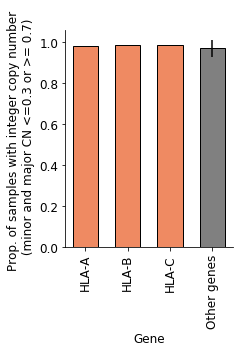

In [12]:
fig,ax = plt.subplots(figsize=(3,4))
j=0
colors=["#760b23ff","#2d1a67ff","#063b07ff"]
for i,value in enumerate(k.items()):
    key,v=value
    if key !="total":
        ax.bar(x=j,height=v/df.shape[0],color="#ef8a62",width=0.6,edgecolor="black")
        j+=1
ax.bar(x=j,height=np.nanmean(values),yerr=np.nanstd(values),color="grey",width=0.6,edgecolor="black")
ax.set_xticks(range(0,4))
ax.set_xticklabels(["HLA-A","HLA-B","HLA-C","Other genes"],rotation=90)

ax.set_ylabel("Prop. of samples with integer copy number \n (minor and major CN <=0.3 or >= 0.7)",fontsize=12)
ax.set_xlabel("Gene",fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

